In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-image
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,539 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
import tempfile
import shutil

## PRAPROSES DATA

In [ ]:
def set_image_dpi(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(3000, 3000))
    return temp_filename

In [ ]:
# Tentukan folder input dan output
train_folder = '/content/drive/My Drive/Lomba Gamafest IPB/Train_resized/'
output_folder = '/content/drive/My Drive/Lomba Gamafest IPB/Processed/'

# Pastikan folder output ada, jika tidak buat folder baru
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterasi melalui gambar-gambar di folder train
for filename in os.listdir(train_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(train_folder, filename)

        # Meningkatkan ukuran gambar
        resized_image_path = set_image_dpi(image_path)

        # Simpan gambar yang telah diproses
        output_path = os.path.join(output_folder, filename)
        shutil.copy(resized_image_path, output_path)

<ipython-input-35-7cc49c31ab62>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im.resize(size, Image.ANTIALIAS)


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
train = '/content/drive/My Drive/Gamafest IPB/Processed/'
test = '/content/drive/My Drive/Gamafest IPB/Test/'
label = pd.read_csv('/content/drive/My Drive/Gamafest IPB/label.csv')

In [ ]:
label.head()

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_001,159,9,2
1,TPS_002,112,87,2
2,TPS_003,173,27,3
3,TPS_004,207,20,3
4,TPS_005,213,30,4


## Praproses Data

In [ ]:
# Fungsi untuk praproses gambar
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

# Fungsi untuk membuat bounding box pada gambar
def draw_bounding_boxes(image, bounding_boxes):
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

# Fungsi untuk mengambil ROI dari gambar berdasarkan bounding box
def extract_roi(image, bounding_box):
    x1, y1, x2, y2 = bounding_box
    roi = image[y1:y2, x1:x2]
    return roi

# Fungsi untuk menyimpan ROI ke folder yang sesuai
def save_roi_to_folder(roi, folder_path, file_name):
    cv2.imwrite(os.path.join(folder_path, file_name), roi)

# Fungsi untuk mengubah resolusi gambar menjadi 3000 dpi
def set_image_dpi(image, dpi):
    im_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    width, height = im_pil.size
    new_size = (int(width * dpi / 300), int(height * dpi / 300))
    im_resized = im_pil.resize(new_size, Image.ANTIALIAS)
    return cv2.cvtColor(np.array(im_resized), cv2.COLOR_RGB2BGR)

In [ ]:
# Looping untuk semua gambar dalam folder train
train_folder = '/content/drive/My Drive/Gamafest IPB/Processed/'
roi_folder = '/content/drive/My Drive/Gamafest IPB/ROI/'

In [ ]:
# Pastikan folder output ada, jika tidak buat folder baru
if not os.path.exists(roi_folder):
    os.makedirs(roi_folder)

for image_file in os.listdir(train_folder):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # Membaca gambar
        image_path = os.path.join(train_folder, image_file)
        image = cv2.imread(image_path)

        # Praproses gambar
        preprocessed_image = preprocess_image(image)

        # Bounding box yang telah ditentukan
        bounding_boxes = [
            (780, 45, 990, 110),  # bbx 1
            (780, 370, 990, 440),  # bbx 2
            (780, 690, 990, 760)   # bbx 3
        ]

        # Looping untuk setiap bounding box
        for i, bounding_box in enumerate(bounding_boxes):
            # Ekstrak ROI
            roi = extract_roi(preprocessed_image, bounding_box)

            # Ubah skala gambar ROI menjadi 3000 dpi
            roi_high_res = set_image_dpi(roi, dpi=3000)

            # Simpan ROI ke folder yang sesuai
            roi_folder_path = os.path.join(roi_folder, 'ROI {}'.format(i+1))
            if not os.path.exists(roi_folder_path):
                os.makedirs(roi_folder_path)
            save_roi_to_folder(roi_high_res, roi_folder_path, image_file)

<ipython-input-26-9d562b8df206>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_pil.resize(new_size, Image.ANTIALIAS)


## Read Data ROI

In [ ]:
import random

In [ ]:
roi1_folder = '/content/drive/My Drive/Gamafest IPB/ROI/ROI 1'
roi2_folder = '/content/drive/My Drive/Gamafest IPB/ROI/ROI 2'
roi3_folder = '/content/drive/My Drive/Gamafest IPB/ROI/ROI 3'

In [ ]:
def display_images(image_paths):
    plt.figure(figsize=(10, 5))
    for i, image_path in enumerate(image_paths, 1):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(image)
    plt.show()

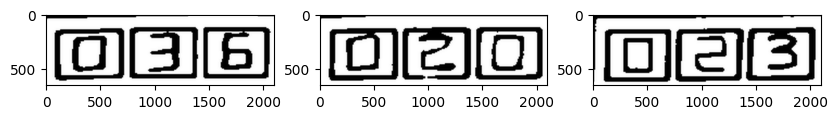

In [ ]:
files = os.listdir(roi1_folder)
random_files = random.sample(files, 3)
image_paths = [os.path.join(roi1_folder, file) for file in random_files]
display_images(image_paths)

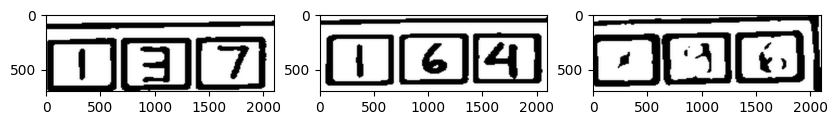

In [ ]:
files = os.listdir(roi2_folder)
random_files = random.sample(files, 3)
image_paths = [os.path.join(roi2_folder, file) for file in random_files]
display_images(image_paths)

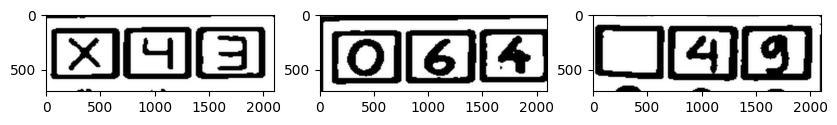

In [ ]:
files = os.listdir(roi3_folder)
random_files = random.sample(files, 3)
image_paths = [os.path.join(roi3_folder, file) for file in random_files]
display_images(image_paths)

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:
import cv2
import matplotlib.pyplot as plt

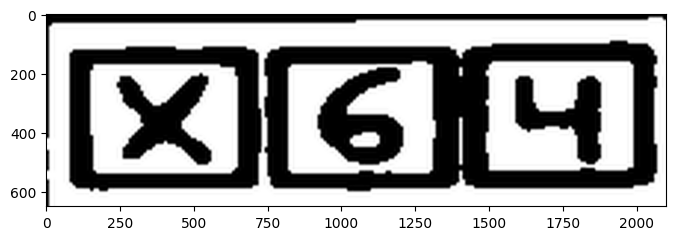

In [ ]:
# Baca gambar
img = cv2.imread('/content/drive/My Drive/Gamafest IPB/ROI/ROI 1/TPS_500.jpg')

# Konversi warna gambar dari BGR ke RGB (Matplotlib menggunakan format RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Tampilkan gambar dengan ukuran
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.show()


In [ ]:
import pytesseract

In [ ]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

'\x0c'

In [ ]:
import easyocr

In [ ]:
# Inisialisasi EasyOCR dengan bahasa yang diinginkan
reader = easyocr.Reader(['en'])

# Baca teks dari gambar
result = reader.readtext('/content/drive/My Drive/Gamafest IPB/ROI/ROI 1/TPS_500.jpg')

# Tampilkan hasil
for detection in result:
    print(detection[1])

P
6


## Data

#### CROP ROI

In [ ]:
# Fungsi untuk membagi ROI menjadi tiga bagian
def split_roi(roi):
    roi_width = roi.shape[1]
    roi_height = roi.shape[0]
    roi_parts = []

    # Bagi ROI menjadi tiga bagian
    part_width = roi_width // 3
    for i in range(3):
        start_x = i * part_width
        end_x = (i + 1) * part_width
        roi_part = roi[:, start_x:end_x]
        roi_parts.append(roi_part)

    return roi_parts

# Fungsi untuk melakukan cropping dan menyimpan hasilnya
def crop_and_save(image_folder, crop_folder, roi_index):
    # Pastikan folder untuk menyimpan hasil cropping ada
    if not os.path.exists(crop_folder):
        os.makedirs(crop_folder)

    # Looping untuk setiap gambar dalam folder
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            # Baca gambar ROI
            roi_path = os.path.join(image_folder, image_file)
            roi = cv2.imread(roi_path)

            # Bagi ROI menjadi tiga bagian
            roi_parts = split_roi(roi)

            # Simpan setiap bagian dalam folder yang sesuai
            for i, roi_part in enumerate(roi_parts):
                crop_path = os.path.join(crop_folder, 'ROI{}_{}_{}.jpg'.format(roi_index, image_file[:-4], i+1))
                cv2.imwrite(crop_path, roi_part)

In [ ]:
# Folder ROI dan folder untuk menyimpan hasil cropping
roi_folders = ['/content/drive/My Drive/Gamafest IPB/ROI/ROI 1',
               '/content/drive/My Drive/Gamafest IPB/ROI/ROI 2',
               '/content/drive/My Drive/Gamafest IPB/ROI/ROI 3']
crop_train_folder = '/content/drive/My Drive/Gamafest IPB/CROP_TRAIN'

# Pastikan folder untuk menyimpan hasil cropping (crop_train_folder) ada
if not os.path.exists(crop_train_folder):
    os.makedirs(crop_train_folder)

# Lakukan cropping dan simpan untuk setiap folder ROI
for i, roi_folder in enumerate(roi_folders, start=1):
    crop_and_save(roi_folder, os.path.join(crop_train_folder, 'ROI_{}'.format(i)), i)

## CNN

In [ ]:
pip install split-folders

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import splitfolders
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import pandas as pd

#### Split Data

In [ ]:
# Directory Utama
main_path = '/content/drive/My Drive/Gamafest IPB/DATA'

In [ ]:
#splitfolders.ratio(
#     main_path,
#     output='/content/drive/My Drive/Gamafest IPB/DATASET',
#     ratio=(0.8, 0.2)
#)

In [ ]:
# Directory List
train_path = '/content/drive/My Drive/Gamafest IPB/DATASET/train/'
val_path = '/content/drive/My Drive/Gamafest IPB/DATASET/val/'

#### Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_path,
                                                batch_size=32,
                                                target_size=(128, 128),
                                                class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(val_path,
                                            batch_size=32,
                                            target_size=(128, 128),
                                            class_mode='categorical')

Found 2725 images belonging to 11 classes.
Found 688 images belonging to 11 classes.


In [ ]:
# List Nama Kelas
class_names = ['X', '0', '9', '8', '1', '7', '6', '2', '5', '3', '4']
class_names

['X', '0', '9', '8', '1', '7', '6', '2', '5', '3', '4']

#### Data Analisis dan Visualisasi

In [ ]:
# List untuk mengisi nama kelas dan jumlah data dari masing2 label
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(main_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

print("Kelas             :",class_names)
print(f"Total Data        : [{len(tag)}]")
print("====================================")
print("Jumlah Gambar     :")
df = pd.DataFrame({"path":full_path,'file_name':file_name,"Nama":tag})
df.groupby(['Nama']).size()

Kelas             : ['X', '0', '9', '8', '1', '7', '6', '2', '5', '3', '4']
Total Data        : [3413]
Jumlah Gambar     :


Nama
0    363
1    612
2    276
3    201
4    225
5    198
6    162
7    173
8    156
9    170
X    877
dtype: int64

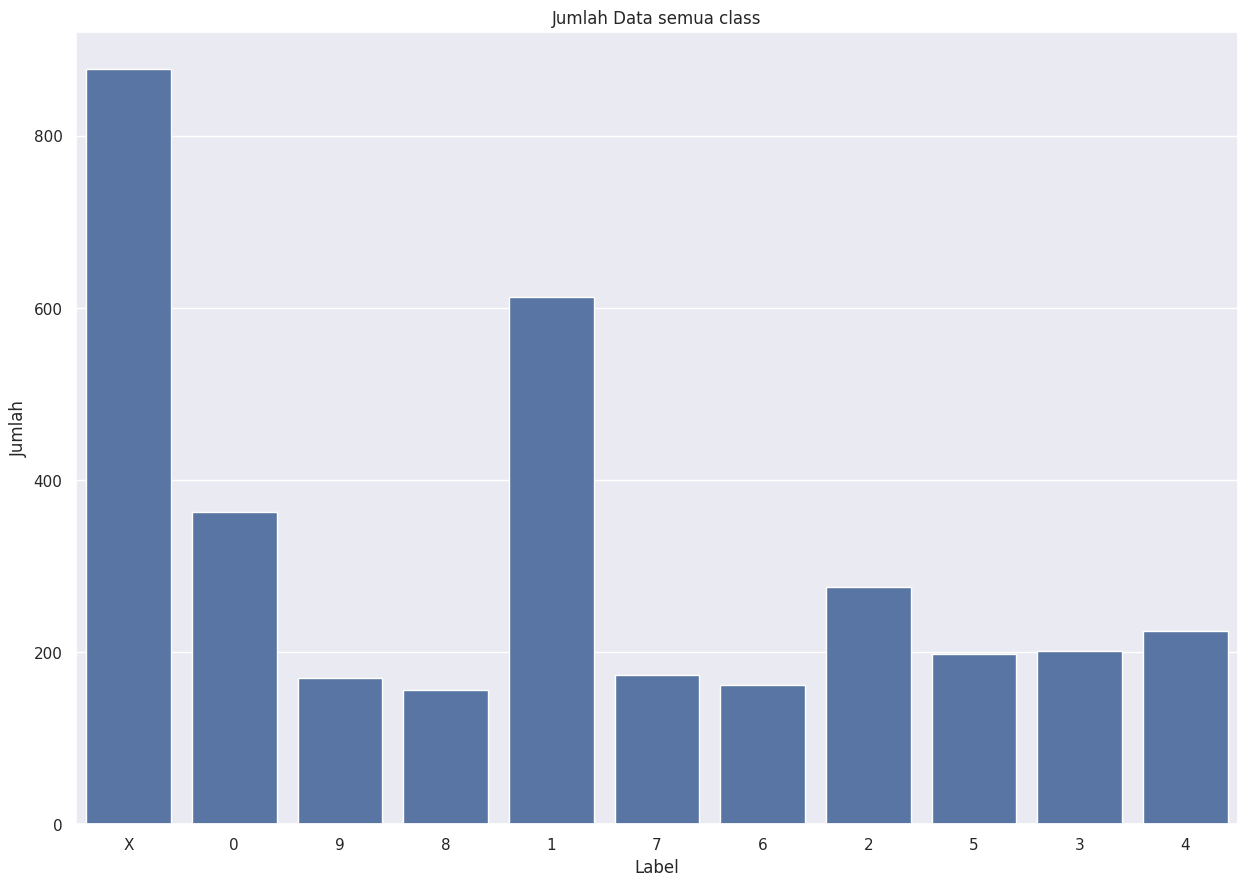

In [ ]:
plt.figure(figsize=(15, 35))
sns.set_theme()
plt.subplot(3, 1, 1)
sns.countplot(x=tag)
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Jumlah Data semua class')
plt.show()

In [ ]:
file_name = []
TR = []
full_path = []

for path, subdirs, files in os.walk(train_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        TR.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"Train":TR})
df.groupby(['Train']).size()

Train
0    290
1    489
2    220
3    160
4    180
5    158
6    129
7    138
8    124
9    136
X    701
dtype: int64

In [ ]:
file_name = []
VL = []
full_path = []

for path, subdirs, files in os.walk(val_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        VL.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"Validation":VL})
df.groupby(['Validation']).size()

Validation
0     73
1    123
2     56
3     41
4     45
5     40
6     33
7     35
8     32
9     34
X    176
dtype: int64

#### Data

In [ ]:
paths_train = [path.parts[-2:] for path in
        Path(train_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_trainpath = pd.DataFrame(data=paths_train, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_trainpath = df_trainpath.sort_values('Class', ascending=True) #sorting nama Class
df_trainpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_trainpath

,Class,Image
0,0,ROI2_TPS_145_1.jpg
1,0,ROI2_TPS_291_3.jpg
2,0,ROI2_TPS_289_3.jpg
3,0,ROI2_TPS_282_2.jpg
4,0,ROI2_TPS_268_1.jpg
...,...,...
2720,X,ROI3_TPS_049_1.jpg
2721,X,ROI3_TPS_048_1.jpg
2722,X,ROI3_TPS_043_2.jpg
2723,X,ROI3_TPS_037_1.jpg


In [ ]:
paths_val = [path.parts[-2:] for path in
        Path(val_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_valpath = pd.DataFrame(data=paths_val, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_valpath = df_valpath.sort_values('Class', ascending=True) #sorting nama Class
df_valpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_valpath

,Class,Image
0,0,ROI2_TPS_258_1.jpg
1,0,ROI3_TPS_093_1.jpg
2,0,ROI3_TPS_045_2.jpg
3,0,ROI3_TPS_033_1.jpg
4,0,ROI2_TPS_442_2.jpg
...,...,...
683,X,ROI3_TPS_136_1.jpg
684,X,ROI3_TPS_115_1.jpg
685,X,ROI3_TPS_119_1.jpg
686,X,ROI3_TPS_111_2.jpg


In [ ]:
train_pie = df_trainpath['Class'].value_counts().rename_axis("Class").reset_index(name="Image")
val_pie = df_valpath['Class'].value_counts().rename_axis("Class").reset_index(name="Image")

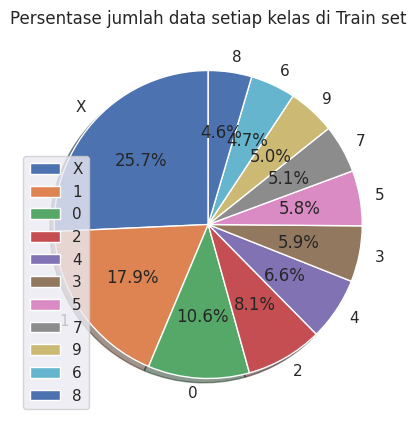

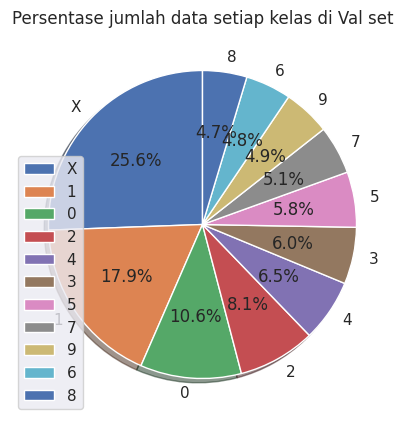

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(
    train_pie['Image'],
    labels=train_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Train set")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.pie(
    val_pie['Image'],
    labels=val_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Val set")
plt.legend()
plt.show()

#### Modelling

In [ ]:
model = tf.keras.Sequential([

#Input layer
tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape=[128, 128, 3]),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

#Hidden layer
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
tf.keras.layers.Flatten(),

#Output layer
tf.keras.layers.Dense(11, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        4

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.95):
            self.model.stop_training = True

In [ ]:
hasil = model.fit(train_set, epochs=50, validation_data=val_set, verbose=1, callbacks=[myCallback()])

Epoch 1/50
86/86 [==============================] - 780s 9s/step - loss: 1.9895 - accuracy: 0.3486 - val_loss: 1.7145 - val_accuracy: 0.5015
Epoch 2/50
86/86 [==============================] - 18s 207ms/step - loss: 1.2928 - accuracy: 0.6066 - val_loss: 1.3343 - val_accuracy: 0.6250
Epoch 3/50
86/86 [==============================] - 18s 208ms/step - loss: 0.9635 - accuracy: 0.7068 - val_loss: 0.9782 - val_accuracy: 0.7297
Epoch 4/50
86/86 [==============================] - 19s 216ms/step - loss: 0.7506 - accuracy: 0.7750 - val_loss: 1.0128 - val_accuracy: 0.7398
Epoch 5/50
86/86 [==============================] - 18s 207ms/step - loss: 0.6061 - accuracy: 0.8187 - val_loss: 0.8327 - val_accuracy: 0.7747
Epoch 6/50
86/86 [==============================] - 18s 210ms/step - loss: 0.4820 - accuracy: 0.8594 - val_loss: 0.8360 - val_accuracy: 0.7878
Epoch 7/50
86/86 [==============================] - 18s 204ms/step - loss: 0.3895 - accuracy: 0.8778 - val_loss: 0.7799 - val_accuracy: 0.7878
E

#### Visualisasi perbandingan Akurasi dan Loss Model

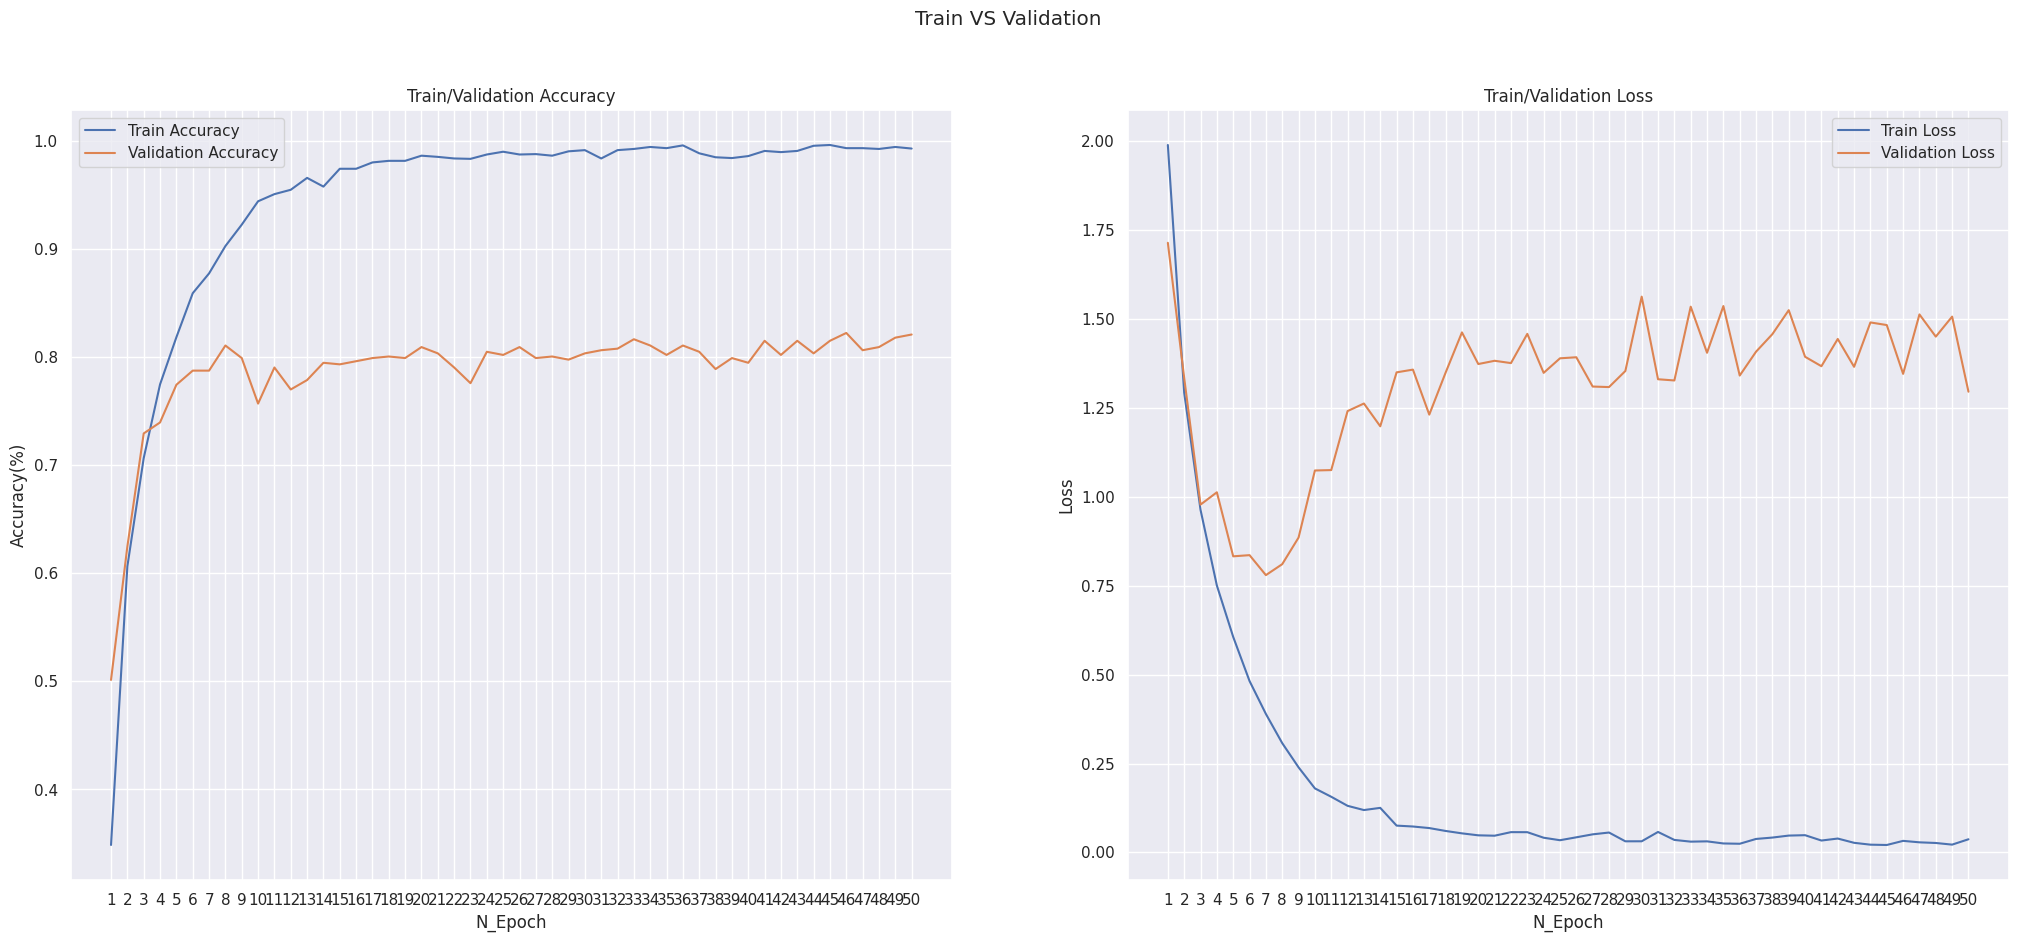

In [ ]:
# Visualisasi akurasi dan loss dari fitting

epoch = [i+1 for i in range(50)]

plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epoch,y = hasil.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epoch,y = hasil.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epoch)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epoch,y = hasil.history['loss'],label ='Train Loss')
sns.lineplot(x=epoch,y = hasil.history['val_loss'],label ='Validation Loss')

plt.xticks(epoch)
plt.title("Train/Validation Loss")
plt.xlabel('N_Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Save Model
model.save('/content/drive/My Drive/Gamafest IPB/Model Saved')
model.save('/content/drive/My Drive/Gamafest IPB/Model Saved/Model Saved.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### DATA TEST

Praproses data resize dan upscale

In [ ]:
def set_image_dpi(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(3000, 3000))
    return temp_filename

In [ ]:
# Tentukan folder input dan output
test_folder = '/content/drive/My Drive/Gamafest IPB/Test_resized/'
output_folder = '/content/drive/My Drive/Gamafest IPB/Test Processed/'

# Pastikan folder output ada, jika tidak buat folder baru
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterasi melalui gambar-gambar di folder train
for filename in os.listdir(test_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(test_folder, filename)

        # Meningkatkan ukuran gambar
        resized_image_path = set_image_dpi(image_path)

        # Simpan gambar yang telah diproses
        output_path = os.path.join(output_folder, filename)
        shutil.copy(resized_image_path, output_path)

<ipython-input-20-7cc49c31ab62>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im.resize(size, Image.ANTIALIAS)


ROI data Test

In [ ]:
# Fungsi untuk praproses gambar
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

# Fungsi untuk membuat bounding box pada gambar
def draw_bounding_boxes(image, bounding_boxes):
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

# Fungsi untuk mengambil ROI dari gambar berdasarkan bounding box
def extract_roi(image, bounding_box):
    x1, y1, x2, y2 = bounding_box
    roi = image[y1:y2, x1:x2]
    return roi

# Fungsi untuk menyimpan ROI ke folder yang sesuai
def save_roi_to_folder(roi, folder_path, file_name):
    cv2.imwrite(os.path.join(folder_path, file_name), roi)

# Fungsi untuk mengubah resolusi gambar menjadi 3000 dpi
def set_image_dpi(image, dpi):
    im_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    width, height = im_pil.size
    new_size = (int(width * dpi / 300), int(height * dpi / 300))
    im_resized = im_pil.resize(new_size, Image.ANTIALIAS)
    return cv2.cvtColor(np.array(im_resized), cv2.COLOR_RGB2BGR)

In [ ]:
# Looping untuk semua gambar dalam folder train
test_folder = '/content/drive/My Drive/Gamafest IPB/Test Processed/'
roi_folder = '/content/drive/My Drive/Gamafest IPB/Test ROI/'

In [ ]:
# Pastikan folder output ada, jika tidak buat folder baru
if not os.path.exists(roi_folder):
    os.makedirs(roi_folder)

for image_file in os.listdir(test_folder):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # Membaca gambar
        image_path = os.path.join(test_folder, image_file)
        image = cv2.imread(image_path)

        # Praproses gambar
        preprocessed_image = preprocess_image(image)

        # Bounding box yang telah ditentukan
        bounding_boxes = [
            (780, 45, 990, 110),  # bbx 1
            (780, 370, 990, 440),  # bbx 2
            (780, 690, 990, 760)   # bbx 3
        ]

        # Looping untuk setiap bounding box
        for i, bounding_box in enumerate(bounding_boxes):
            # Ekstrak ROI
            roi = extract_roi(preprocessed_image, bounding_box)

            # Ubah skala gambar ROI menjadi 3000 dpi
            roi_high_res = set_image_dpi(roi, dpi=3000)

            # Simpan ROI ke folder yang sesuai
            roi_folder_path = os.path.join(roi_folder, 'ROI {}'.format(i+1))
            if not os.path.exists(roi_folder_path):
                os.makedirs(roi_folder_path)
            save_roi_to_folder(roi_high_res, roi_folder_path, image_file)

<ipython-input-24-9d562b8df206>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_pil.resize(new_size, Image.ANTIALIAS)


#### PREDIKSI

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
# Fungsi untuk membagi gambar menjadi 3 bagian
def split_image(image):
    height, width, _ = image.shape
    third = width // 3
    img1 = image[:, :third, :]
    img2 = image[:, third:2*third, :]
    img3 = image[:, 2*third:, :]
    return img1, img2, img3

# Fungsi untuk memprediksi kelas dari gambar
def predict_class(image, model):
    image = cv2.resize(image, (128, 128))  # Resize gambar ke ukuran yang diharapkan oleh model
    image = np.expand_dims(image, axis=0)  # Tambahkan dimensi batch
    image = image / 255.0  # Normalisasi gambar
    prediction = model.predict(image)  # Lakukan prediksi
    return np.argmax(prediction)  # Ambil kelas dengan nilai probabilitas tertinggi

In [ ]:
# Path ke folder ROI Paslon 1
roi1_folder = '/content/drive/My Drive/Gamafest IPB/Test ROI/ROI 1'

In [ ]:
# Path ke model CNN yang telah dilatih
model_path = '/content/drive/My Drive/Gamafest IPB/Model Saved/Model Saved.h5'
model = tf.keras.models.load_model(model_path)

In [ ]:
# Inisialisasi list untuk menyimpan hasil prediksi
predictions = []

# Loop through ROI Paslon 1
for image_file in os.listdir(roi1_folder):
    # Baca gambar ROI
    image_path = os.path.join(roi1_folder, image_file)
    roi_image = cv2.imread(image_path)

    # Bagi gambar menjadi 3 bagian
    img1, img2, img3 = split_image(roi_image)

    # Lakukan prediksi kelas untuk setiap bagian gambar
    prediction1 = predict_class(img1, model)
    prediction2 = predict_class(img2, model)
    prediction3 = predict_class(img3, model)

    # Gabungkan hasil prediksi menjadi satu
    combined_prediction = str(prediction1) + str(prediction2) + str(prediction3)

    # Simpan hasil prediksi ke dalam list
    predictions.append({'tps': image_file, 'suara_paslon_1': combined_prediction})

# Buat DataFrame dari list predictions
predictions_df = pd.DataFrame(predictions)

1/1 [==============================] - 0s 18ms/step


In [ ]:
predictions_df.head()

,tps,suara_paslon_1
0,TPS_698.jpg,10104
1,TPS_506.jpg,1069
2,TPS_505.jpg,1059
3,TPS_504.jpg,1021
4,TPS_507.jpg,1005


In [ ]:
# Path ke folder ROI Paslon 2
roi2_folder = '/content/drive/My Drive/Gamafest IPB/Test ROI/ROI 2'

In [ ]:
# Inisialisasi list untuk menyimpan hasil prediksi ROI 2
predictions_roi2 = []

# Loop through ROI Paslon 2
for image_file in os.listdir(roi2_folder):
    # Baca gambar ROI
    image_path = os.path.join(roi2_folder, image_file)
    roi_image = cv2.imread(image_path)

    # Bagi gambar menjadi 3 bagian
    img1, img2, img3 = split_image(roi_image)

    # Lakukan prediksi kelas untuk setiap bagian gambar
    prediction1 = predict_class(img1, model)
    prediction2 = predict_class(img2, model)
    prediction3 = predict_class(img3, model)

    # Gabungkan hasil prediksi menjadi satu
    combined_prediction = str(prediction1) + str(prediction2) + str(prediction3)

    # Simpan hasil prediksi ke dalam list
    predictions_roi2.append({'tps': image_file, 'suara_paslon_2': combined_prediction})

# Buat DataFrame dari list predictions_roi2
predictions_df_roi2 = pd.DataFrame(predictions_roi2)

1/1 [==============================] - 0s 19ms/step


In [ ]:
predictions_df_roi2.head()

,tps,suara_paslon_2
0,TPS_506.jpg,120
1,TPS_505.jpg,172
2,TPS_504.jpg,153
3,TPS_507.jpg,110
4,TPS_508.jpg,126


In [ ]:
# Path ke folder ROI Paslon 3
roi3_folder = '/content/drive/My Drive/Gamafest IPB/Test ROI/ROI 3'

In [ ]:
# Inisialisasi list untuk menyimpan hasil prediksi ROI 3
predictions_roi3 = []

# Loop through ROI Paslon 3
for image_file in os.listdir(roi3_folder):
    # Baca gambar ROI
    image_path = os.path.join(roi3_folder, image_file)
    roi_image = cv2.imread(image_path)

    # Bagi gambar menjadi 3 bagian
    img1, img2, img3 = split_image(roi_image)

    # Lakukan prediksi kelas untuk setiap bagian gambar
    prediction1 = predict_class(img1, model)
    prediction2 = predict_class(img2, model)
    prediction3 = predict_class(img3, model)

    # Gabungkan hasil prediksi menjadi satu
    combined_prediction = str(prediction1) + str(prediction2) + str(prediction3)

    # Simpan hasil prediksi ke dalam list
    predictions_roi3.append({'tps': image_file, 'suara_paslon_3': combined_prediction})

# Buat DataFrame dari list predictions_roi3
predictions_df_roi3 = pd.DataFrame(predictions_roi3)

1/1 [==============================] - 0s 17ms/step


In [ ]:
predictions_df_roi3.head()

,tps,suara_paslon_3
0,TPS_506.jpg,1031
1,TPS_505.jpg,1017
2,TPS_504.jpg,1041
3,TPS_507.jpg,1041
4,TPS_508.jpg,1038


#### GABUNG DATA

In [ ]:
# Gabungkan DataFrame predictions_df dan predictions_df_roi2 berdasarkan kolom tps
merged_df = predictions_df.merge(predictions_df_roi2, on='tps', how='left')

# Gabungkan DataFrame merged_df dan predictions_df_roi3 berdasarkan kolom tps
merged_df = merged_df.merge(predictions_df_roi3, on='tps', how='left')

In [ ]:
merged_df.head()

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_698.jpg,10104,144,1038
1,TPS_506.jpg,1069,120,1031
2,TPS_505.jpg,1059,172,1017
3,TPS_504.jpg,1021,153,1041
4,TPS_507.jpg,1005,110,1041


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tps             200 non-null    object
 1   suara_paslon_1  200 non-null    object
 2   suara_paslon_2  200 non-null    object
 3   suara_paslon_3  200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [ ]:
# Fungsi untuk menghapus nilai 10 pada kolom 2 angka pertama
def remove_10(x):
    if len(x) >= 2 and x[:2] == '10':
        return x[2:]
    else:
        return x

# Terapkan fungsi remove_10 pada kolom suara_paslon_1, suara_paslon_2, dan suara_paslon_3
merged_df['suara_paslon_1'] = merged_df['suara_paslon_1'].apply(remove_10)
merged_df['suara_paslon_2'] = merged_df['suara_paslon_2'].apply(remove_10)
merged_df['suara_paslon_3'] = merged_df['suara_paslon_3'].apply(remove_10)

In [ ]:
merged_df.head()

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_698.jpg,104,144,38
1,TPS_506.jpg,69,120,31
2,TPS_505.jpg,59,172,17
3,TPS_504.jpg,21,153,41
4,TPS_507.jpg,05,110,41


In [ ]:
# Konversi nilai kolom suara_paslon_1, suara_paslon_2, dan suara_paslon_3 ke tipe data numerik
merged_df['suara_paslon_1'] = pd.to_numeric(merged_df['suara_paslon_1'])
merged_df['suara_paslon_2'] = pd.to_numeric(merged_df['suara_paslon_2'])
merged_df['suara_paslon_3'] = pd.to_numeric(merged_df['suara_paslon_3'])

# Buat kolom total
merged_df['total_suara'] = merged_df['suara_paslon_1'] + merged_df['suara_paslon_2'] + merged_df['suara_paslon_3']

# Buat kolom persentase suara paslon 2
merged_df['persentase_suara_paslon_2'] = (merged_df['suara_paslon_2'] / merged_df['total_suara']) * 100

In [ ]:
# Ubah nama kolom 'tps' menjadi 'TPS' pada DataFrame merged_df
merged_df.rename(columns={'tps': 'TPS'}, inplace=True)

In [ ]:
merged_df.head()

,TPS,suara_paslon_1,suara_paslon_2,suara_paslon_3,total_suara,persentase_suara_paslon_2
0,TPS_698,104,144,38,286,50.349650
1,TPS_506,69,120,31,220,54.545455
2,TPS_505,59,172,17,248,69.354839
3,TPS_504,21,153,41,215,71.162791
4,TPS_507,5,110,41,156,70.512821


In [ ]:
# Simpan DataFrame ke file CSV
merged_df.to_csv('/content/drive/My Drive/Gamafest IPB/data_akhir.csv', index=False)

In [ ]:
# Path ke file submission CSV
submission_path = '/content/drive/My Drive/Gamafest IPB/sample_submission.csv'

# Baca file submission CSV
submission_df = pd.read_csv(submission_path)

In [ ]:
submission_df.head()

,TPS,Persentase Suara Sah Paslon 2
0,TPS_501,NaN
1,TPS_502,NaN
2,TPS_503,NaN
3,TPS_504,NaN
4,TPS_505,NaN


In [ ]:
# Ubah nilai pada kolom 'TPS' dari merged_df agar tidak memiliki ekstensi ".jpg"
merged_df['TPS'] = merged_df['TPS'].str.replace('.jpg', '')

# Gabungkan submission_df dengan merged_df berdasarkan kolom 'TPS'
submission_merged_df = submission_df.merge(merged_df, on='TPS', how='left')

# Isi nilai kolom 'Persentase Suara Sah Paslon 2' pada submission_df dengan nilai dari kolom 'persentase_suara_paslon_2' dari merged_df
submission_merged_df['Persentase Suara Sah Paslon 2'] = submission_merged_df['persentase_suara_paslon_2']

In [ ]:
submission_merged_df.head()

,TPS,Persentase Suara Sah Paslon 2,suara_paslon_1,suara_paslon_2,suara_paslon_3,total_suara,persentase_suara_paslon_2
0,TPS_501,60.256410,77,141,16,234,60.256410
1,TPS_502,17.959184,155,44,46,245,17.959184
2,TPS_503,72.532189,41,169,23,233,72.532189
3,TPS_504,71.162791,21,153,41,215,71.162791
4,TPS_505,69.354839,59,172,17,248,69.354839


In [ ]:
# Drop kolom-kolom yang tidak diperlukan
submission_final_df = submission_merged_df.drop(['suara_paslon_1', 'suara_paslon_2', 'suara_paslon_3', 'total_suara', 'persentase_suara_paslon_2'], axis=1)

In [ ]:
submission_final_df.head()

,TPS,Persentase Suara Sah Paslon 2
0,TPS_501,60.256410
1,TPS_502,17.959184
2,TPS_503,72.532189
3,TPS_504,71.162791
4,TPS_505,69.354839


In [ ]:
# Simpan DataFrame ke file CSV
submission_final_df.to_csv('/content/drive/My Drive/Gamafest IPB/submission_final.csv', index=False)